# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.offline as py
template_style = "plotly_dark"
%matplotlib inline

In [2]:
df = pd.read_excel('../Database/basededatos.xlsx')

/Users/isaacmenchaca/PycharmProjects/Tesis/.venv/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning:

Unknown extension is not supported and will be removed



##### Remove duplicates and null values  

In [3]:
# the porcentage of missing values is   10,999 - 3.9%
# the porcentage of duplicates is       9,160  - 3.3%
df_without_duplicates = df.drop_duplicates()
df_without_duplicates_and_na = df_without_duplicates.dropna()
# 19008 data removed

##### Convert values to absolute values

In [4]:
df_absolut_values = df_without_duplicates_and_na.copy()
df_absolut_values['tiempo_espera_triage'] = df_without_duplicates_and_na['tiempo_espera_triage'].abs()
df_absolut_values['tiempo_en_triage'] = df_without_duplicates_and_na['tiempo_en_triage'].abs()
df_absolut_values['tiempo_espera_despuestriage'] = df_without_duplicates_and_na['tiempo_espera_despuestriage'].abs()
df_absolut_values['tiempo_en_consulta'] = df_without_duplicates_and_na['tiempo_en_consulta'].abs()
df_absolut_values['edad'] = df_without_duplicates_and_na['edad'].abs()

# create a column with the total time
df_absolut_values['tiempo_total'] = df_absolut_values['tiempo_espera_triage'] + df_absolut_values['tiempo_en_triage'] + df_absolut_values['tiempo_espera_despuestriage'] + df_absolut_values['tiempo_en_consulta']

In [5]:
# remove hora column and change name of 'Fecha' to 'fecha'
df_absolut_values = df_absolut_values.drop(columns=['Hora'])
df_absolut_values.rename(columns={'Fecha':'fecha'}, inplace=True)

##### Outliers for 'tiempo_total' (IQR) interquartile range


In [6]:
# Calculate the percentiles
twenty_fifth = df_absolut_values['tiempo_total'].quantile(0.25)
seventy_fifth = df_absolut_values['tiempo_total'].quantile(0.75)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (10 * iqr)
lower = twenty_fifth - (10 * iqr)

# Subset the dataset
outliers = df_absolut_values[(df_absolut_values['tiempo_total'] < lower) | (df_absolut_values['tiempo_total'] > upper)]

print(f'Number of outliers: {len(outliers)}')

# the porcentage of 'tiempo_total' outliers is      726 - 0.2%
df_without_outliers = df_absolut_values.drop(outliers.index)

Number of outliers: 726


##### Standardize the value of the age

In [7]:
df_cleaning_edad = df_without_outliers.copy()
df_cleaning_edad.rename(columns={'Edad1': 'edad_unidad'}, inplace=True)
# convert column edad_unidad to numeric.
df_cleaning_edad['edad_unidad'] = df_cleaning_edad['edad_unidad'].replace({'Años': 1, 'Meses': 1/12, 'Dias': 1/365})
# standardize the value of the age
df_cleaning_edad['edad'] = df_cleaning_edad['edad'] * df_cleaning_edad['edad_unidad']

/var/folders/k4/jmfcdlnj0737gj65_12sh9wm0000gn/T/ipykernel_5951/2472631517.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



##### Outliers for 'edad' (IQR)

In [8]:
df_cleaning_edad = df_cleaning_edad.copy()
twenty_fifth = df_cleaning_edad['edad'].quantile(0.25)
seventy_fifth = df_cleaning_edad['edad'].quantile(0.75)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

# Subset the dataset
outliers_edad = df_cleaning_edad[(df_cleaning_edad['edad'] < lower) | (df_cleaning_edad['edad'] > upper)]

print(f'Number of outliers: {len(outliers_edad)}')

# the porcentage of 'edad' outliers is      3 - 0.001%
df_without_outliers_edad = df_cleaning_edad.drop(outliers_edad.index)

Number of outliers: 3


##### Obtain gender

In [9]:
df_gender_detector = df_without_outliers_edad.copy()
import gender_guesser.detector as gender

# Create an gender detector object
d = gender.Detector()

def obtener_genero(nombre):
    # setting the second name, there is a total categorization between 'Ambiguo' y 'Desconocido' of 34,535 names
    nombre = nombre.split()[-1] 
    nombre = nombre.title()
    # if the name is 'Femenino' or 'Masculino' return the name
    # total categorization between 'Ambiguo' y 'Desconocido' of 27,709 names. Recover 6,826 names
    if nombre == 'Femenino' or nombre == 'Masculino':
        return nombre
    else:
        return d.get_gender(nombre)

df_gender_detector['genero'] = df_gender_detector['nombre'].apply(obtener_genero)

df_gender_detector['genero'] = df_gender_detector['genero'].replace({
    'male': 'Masculino',
    'female': 'Femenino',
    'andy': 'Ambiguo',
    'unknown': 'Desconocido', 
    'mostly_male': 'Masculino',
    'mostly_female': 'Femenino'
})

##### Remove 'Ambiguio' and 'Desconocido' values

In [10]:
df_gender_detector_ambiguo = df_gender_detector[(df_gender_detector['genero'] == 'Ambiguo') | (df_gender_detector['genero'] == 'Desconocido')]

# the porcentage of 'df_gender_detector_ambiguo' is      27,709 - 9.9%
df_gender_detector_clean = df_gender_detector.drop(df_gender_detector_ambiguo.index)

##### Encode gender and clasification

In [11]:
from sklearn.preprocessing import OneHotEncoder

# Encode calsification of triage
df_encode = df_gender_detector_clean.copy()
# Encode clasification 'ROJO': 0, 'AMARILLO': 1, 'VERDE': 2
df_encode['clasificacion_encode'] = df_encode['clasificacion'].replace({'ROJO': 0, 'AMARILLO': 1, 'VERDE': 2})

encoder = OneHotEncoder(sparse_output=False)
# Aplicar el codificador a la columna 'genero'
genero_encoded = encoder.fit_transform(df_encode[['genero']])
# Convertir la salida a un DataFrame
genero_encoded_df = pd.DataFrame(genero_encoded, columns=encoder.get_feature_names_out(['genero']), index=df_encode.index)
# Concatenar las columnas codificadas con el DataFrame original
df_encode = pd.concat([df_encode, genero_encoded_df], axis=1)

/var/folders/k4/jmfcdlnj0737gj65_12sh9wm0000gn/T/ipykernel_5951/364347346.py:6: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



##### Caracteristics from Date

In [12]:
df_date = df_encode.copy()
# Extract caracteristics from date
df_date['hora'] = df_date['fecha'].dt.hour
df_date['minuto'] = df_date['fecha'].dt.minute
df_date['mes'] = df_date['fecha'].dt.month
df_date['dia'] = df_date['fecha'].dt.day
df_date['dia_semana'] = df_date['fecha'].dt.dayofweek
df_date.dtypes

fecha                          datetime64[ns]
nombre                                 object
tiempo_espera_triage                  float64
tiempo_en_triage                      float64
tiempo_espera_despuestriage           float64
tiempo_en_consulta                    float64
clasificacion                          object
edad                                  float64
edad_unidad                           float64
Dx                                     object
tiempo_total                          float64
genero                                 object
clasificacion_encode                    int64
genero_Femenino                       float64
genero_Masculino                      float64
hora                                    int32
minuto                                  int32
mes                                     int32
dia                                     int32
dia_semana                              int32
dtype: object

In [13]:
df_date.head()

,fecha,nombre,tiempo_espera_triage,tiempo_en_triage,tiempo_espera_despuestriage,tiempo_en_consulta,clasificacion,edad,edad_unidad,Dx,tiempo_total,genero,clasificacion_encode,genero_Femenino,genero_Masculino,hora,minuto,mes,dia,dia_semana
0,2010-08-16 08:46:15.343,JORGE,7.0,5.0,18.0,14.0,AMARILLO,42.0,1.0,HERIDA DEL LABIO SUPERIOR,44.0,Masculino,1,0.0,1.0,8,46,8,16,0
1,2010-08-16 09:00:35.700,MARIA TERESITA,4.0,5.0,16.0,26.0,AMARILLO,45.0,1.0,PICADURA DE APIE,51.0,Femenino,1,1.0,0.0,9,0,8,16,0
5,2010-08-16 09:37:31.500,JONATHAN BRAYAN,5.0,5.0,51.0,13.0,AMARILLO,8.0,1.0,FRACTURA DE TERCIO MEDIO CLAVICULA IZQ,74.0,Masculino,1,0.0,1.0,9,37,8,16,0
7,2010-08-16 09:44:29.467,ALMA PATRICIA,5.0,4.0,44.0,0.0,AMARILLO,33.0,1.0,COLICO RENOURETERAL REMITIDO + PB UROLITIASIS ...,53.0,Femenino,1,1.0,0.0,9,44,8,16,0
8,2010-08-16 09:49:16.543,ROBERTO,27.0,5.0,71.0,9.0,AMARILLO,34.0,1.0,COLICO RENAL IZQ,112.0,Masculino,1,0.0,1.0,9,49,8,16,0


In [14]:
df_regresion = df_date.copy()

In [15]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# the porcentage of not string values is   9 - 0.003%
df_not_string = df_regresion[~df_regresion['Dx'].apply(lambda x: isinstance(x, str))]
df_regresion = df_regresion.drop(df_not_string.index)

# Create a TaggedDocument object
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df_regresion['Dx'])]

# Create a Doc2Vec model
model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=40)

df_regresion['doc2vec'] = [model.dv[str(i)] for i in range(len(tagged_data))]


In [16]:

df_doc2vec = pd.DataFrame(df_regresion['doc2vec'].tolist(), index=df_regresion.index)
X_doc2vec = pd.concat([df_regresion.drop('doc2vec', axis=1), df_doc2vec], axis=1)
X_doc2vec.drop(columns=['nombre', 'fecha', 'Dx', 'edad_unidad', 'genero', 'clasificacion', 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta', 'tiempo_total'], inplace=True)

# Regression Model

Root Mean Squared Error (RMSE): 35.21387078726506
Mean Squared Error (MSE): 1240.0166958221996
Coeficiente de determinación (R^2): 0.06629795484610845
Mean Absolute Error (MAE): 23.64256122956785
        Actual  Predicted
116587    47.0  76.690983
216523    40.0  49.262402
224856    72.0  55.689958
71903     27.0  47.423715
239500    85.0  62.293982
152620    82.0  49.928606
99181     22.0  46.848856
144965    91.0  48.814639
271439   121.0  52.567436
179217    81.0  49.682427


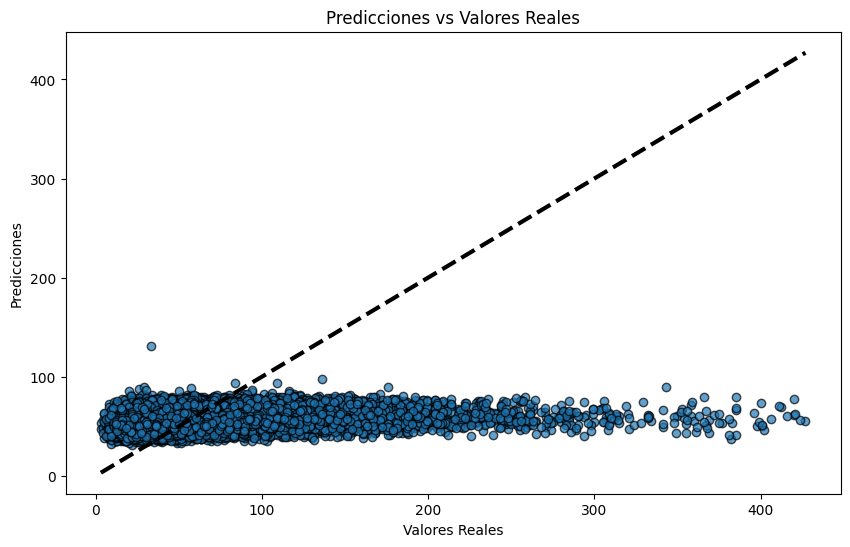

In [17]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select target and features
# X = df_regresion[['clasificacion_encode', 'edad', 'genero_Femenino', 'genero_Masculino', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
X = X_doc2vec
y = df_regresion['tiempo_total']

X.columns = X.columns.astype(str)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Predictions
y_test_pred = model.predict(X_test)


# Métricas de evaluación
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_test_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred)}')

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred.flatten()})
print(predictions.head(10))

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

In [ ]:
# from lazypredict.Supervised import LazyRegressor
# from sklearn.model_selection import train_test_split
# import pandas as pd

# # Supongamos que tienes un DataFrame llamado df_ann
# X = df_regresion[['clasificacion_encode', 'edad', 'genero_encode', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
# # X = df_regresion[['clasificacion_AMARILLO', 'clasificacion_ROJO', 'clasificacion_VERDE', 'edad', 'genero_Femenino', 'genero_Masculino', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
# y = df_regresion['tiempo_total']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt


# # Select target and features
# X = df_regresion[['clasificacion_encode', 'edad', 'genero_encode', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
# # X = df_regresion[['clasificacion_AMARILLO', 'clasificacion_ROJO', 'clasificacion_VERDE', 'edad', 'genero_Femenino', 'genero_Masculino', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
# y = df_regresion['tiempo_total']

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = KNeighborsRegressor()
# param_grid = {'n_neighbors': [90, 95, 100]}

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
# grid_search.fit(X_train, y_train)

# # Obtener los mejores hiperparámetros
# best_params = grid_search.best_params_
# print("Mejores hiperparámetros:", best_params)

# # Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
# best_model = grid_search.best_estimator_

# # Predicciones
# y_test_pred = best_model.predict(X_test)

# ANN Model

In [19]:
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
import numpy as np

# Select target and features
# X = df_ann[['clasificacion_encode', 'edad', 'genero_encode', 'hora', 'minuto', 'mes', 'dia', 'dia_semana', 'tiempo_espera_triage', 'doc2vec']]
# X = df_ann[['clasificacion_encode', 'edad', 'genero_encode', 'hora', 'minuto', 'mes', 'dia', 'dia_semana', 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta']]
# X = df_ann[['clasificacion_AMARILLO', 'clasificacion_ROJO', 'clasificacion_VERDE', 'edad', 'genero_Femenino', 'genero_Masculino', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
# y = df_ann['tiempo_total']

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Configurar la semilla para reproducibilidad
np.random.seed(3000)

# Construcción de la red neuronal
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(420, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.1))
model.add(Dense (198, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.1))
model.add(Dense(98, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.1))
model.add(Dense(1))

# Inicializar el optimizador con una tasa de aprendizaje inicial
initial_learning_rate = 0.0001
optimizer = RMSprop(learning_rate=initial_learning_rate)
#MSprop (Root Mean Square Propagation) es una extensión del método de descenso del gradiente estocástico (SGD)
#que ajusta la tasa de aprendizaje para cada parámetro de forma individual
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Entrenar el modelo
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, verbose=1, callbacks=[reduce_lr, model_checkpoint])

# Evaluación del modelo
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Mean Absolute Error on test data: {mae}')

Epoch 1/100


/Users/isaacmenchaca/PycharmProjects/Tesis/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9242/9248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1612.0817 - mae: 27.0296
Epoch 1: val_loss improved from inf to 1283.65369, saving model to best_model.keras
9248/9248 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1611.9052 - mae: 27.0281 - val_loss: 1283.6537 - val_mae: 24.6822 - learning_rate: 1.0000e-04
Epoch 2/100
9231/9248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1278.3618 - mae: 24.1879
Epoch 2: val_loss improved from 1283.65369 to 1282.89978, saving model to best_model.keras
9248/9248 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1278.3514 - mae: 24.1878 - val_loss: 1282.8998 - val_mae: 23.4806 - learning_rate: 1.0000e-04
Epoch 3/100
9236/9248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1279.4762 - mae: 24.1685
Epoch 3: val_loss improved from 1282.89978 to 1274.72510, saving model to best_model.keras
9248/9248 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1279.4576 - mae: 24.1683 - val_loss: 1274.7251 - val_mae: 23.4685 - learning_rate: 1.0000e-04
Epoch 4/100
9231/9248 ━━━━━━━━━━━━━━━━━━━━ 0

1379/1379 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step
Mean Squared Error (MSE): 0.049934387780567746
Coeficiente de determinación (R^2): 0.9999109372423096
Mean Absolute Error (MAE): 0.1508483028978216
        Actual  Predicted
233951    56.0  56.048870
253572    48.0  48.047718
190358    56.0  55.882969
133836    39.0  38.911819
213986    72.0  71.924294
138331    54.0  53.746780
138474    39.0  38.875412
173297    33.0  32.927166
205967    57.0  56.953934
77484     17.0  16.917500


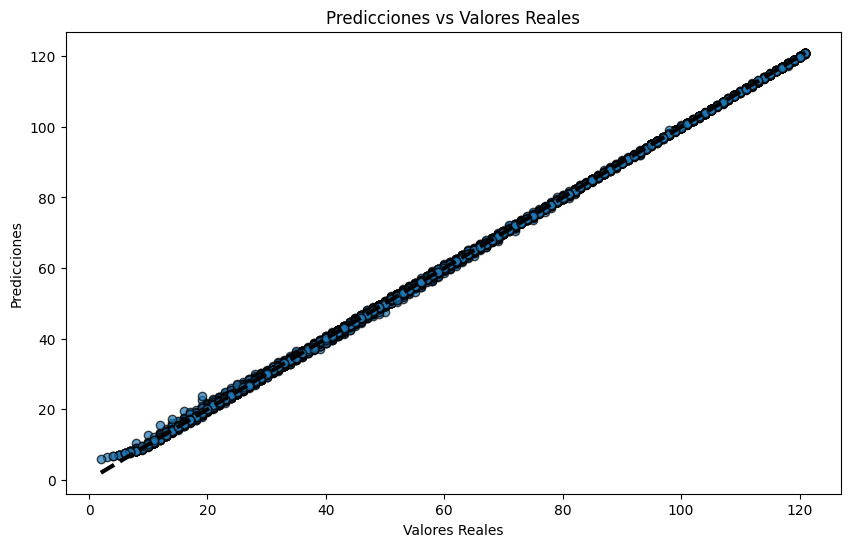

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'learning_rate'])


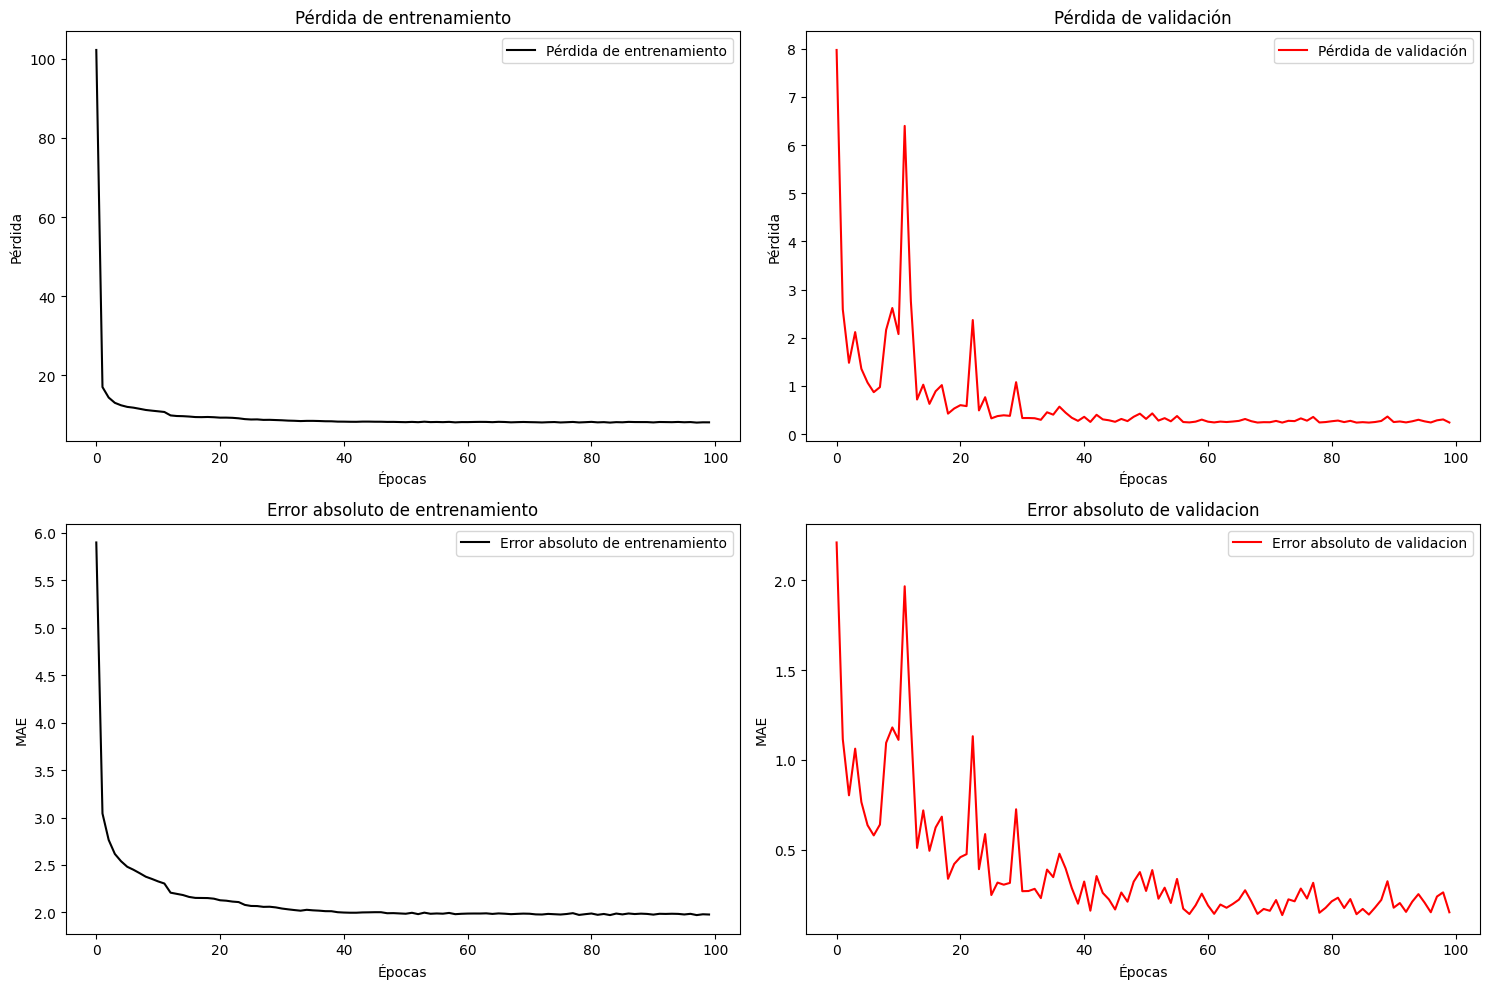

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Predicción
y_pred = model.predict(X_test)


# Métricas de evaluación
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}')

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
print(predictions.head(10))

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

# Imprimir las claves de history.history
print(history.history.keys())

import matplotlib.pyplot as plt


# Crear subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Graficar la pérdida de entrenamiento
axs[0, 0].plot(history.history['loss'], label='Pérdida de entrenamiento', color="black")
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Pérdida')
axs[0, 0].set_title('Pérdida de entrenamiento')
axs[0, 0].legend()

# Graficar la pérdida de validación
axs[0, 1].plot(history.history['val_loss'], label='Pérdida de validación',color="red")
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Pérdida')
axs[0, 1].set_title('Pérdida de validación')
axs[0, 1].legend()

# Graficar MAE de entrenamiento
axs[1, 0].plot(history.history['mae'], label='Error absoluto de entrenamiento', color="black")
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].set_title('Error absoluto de entrenamiento')
axs[1, 0].legend()

# Graficar MAE de validación
axs[1, 1].plot(history.history['val_mae'], label='Error absoluto de validacion', color="red")
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].set_title('Error absoluto de validacion')
axs[1, 1].legend()

# Ajustar diseño para evitar solapamiento
plt.tight_layout()
plt.show()

# Analisys

##### Prepare data

In [ ]:
df_analisys = df_encode.copy()

In [ ]:
df_analisys.rename(columns={'fecha':'date'}, inplace=True)

df_analisys['entry_time'] = df_analisys['date'].dt.time
df_analisys['entry_time'] = pd.to_timedelta(df_analisys.entry_time.astype(str))


df_analisys.rename(columns={'tiempo_total':'waiting_time'}, inplace=True)
df_analisys['waiting_time'] = pd.to_timedelta(df_analisys['waiting_time'], unit='m')

df_analisys['completion_time'] = df_analisys['waiting_time'] + df_analisys['entry_time']

df_analisys['waiting_ber_munets'] = df_analisys.waiting_time.dt.seconds / 60
df_analisys['waiting_ber_munets'] = df_analisys['waiting_ber_munets'].round(0)

df_analisys['weekday'] = df_analisys.date.dt.strftime('%A')                      # new column for extract 'weekday' from 'date'
df_analisys['hours'] = df_analisys.entry_time.dt.components.hours                # new column for extract the  'hours' from 'entry_time'

In [ ]:
df_analisys.dtypes

In [ ]:
df_analisys.drop(columns=['nombre', 'genero', 'Dx'], inplace=True)
df_analisys.head(2)

##### Patient heatmap

In [ ]:

def grouped_data2(column_name):
    if column_name == 'completion_time':                                            
        answer = pd.pivot_table(df_analisys, index='hours', columns=['weekday'], aggfunc='count')
    elif column_name == 'waiting_ber_munets':                                      
        answer = pd.pivot_table(df_analisys, index='hours',                                  
                                columns=['weekday'] , aggfunc='mean').round(1)  
    else:
        return(column_name + " is not in the columns")                              
    
    answer = answer[column_name]
    answer = answer.fillna(0)
    answer = answer[['Sunday', 'Monday', 'Tuesday',                                
                  'Wednesday', 'Thursday', 
                  'Friday', 'Saturday']] 
    return answer
answer3 =  grouped_data2('completion_time')
answer4 =  grouped_data2('waiting_ber_munets')
print(answer3,answer4)

In [ ]:
fig3 = px.imshow(answer3,
                labels=dict(x="weekday", y="hours", color="number of paitant") , 
                aspect="auto", color_continuous_scale='tempo',
                template = template_style,
                text_auto=True, width=900, height=900)
fig3.update_xaxes(side="top")
fig3.show()

##### Hour heatmap

In [ ]:
fig4 = px.imshow(answer4,
                labels=dict(x="weekday", y="hours",
                            color="the waiting time per min") , 
                            aspect="auto", color_continuous_scale='tempo',
                            template = template_style,
                            text_auto=True, width=900, height=900)
fig4.update_xaxes(side="top")
fig4.show()

##### Bar chart

In [ ]:
def grouped_data(column_name):
    '''
    Groupby column and return DataFrame
    Input: Column Name
    '''
    df_tmp = df_analisys.groupby(column_name)[['waiting_ber_munets']].mean().round(0)
    df_tmp2 = df_analisys[column_name].value_counts()      #this for concat
    
    pivot_f = pd.concat([df_tmp, df_tmp2.rename('number_of_patient')],axis=1)
    pivot_f.reset_index(inplace=True)
    pivot_f = pivot_f.rename(columns={'index': column_name })
    return pivot_f

answer5 = grouped_data('hours')
link_size = [3,6]
fig = px.bar(x=answer5['hours'],
             y=answer5['waiting_ber_munets'],
             template= template_style,
             text_auto='.2s',
             labels={'x':'the hour',
                     'y':'the waiting time per m'}
             ).add_traces(
      px.line(answer5, x=answer5['hours'], text='number_of_patient',
             y=answer5['number_of_patient'],markers=True).update_traces(yaxis="y2",
             showlegend=True, line=dict(color = 'red', width=link_size[1]), name="number_of_patient").data)        
fig.update_layout(yaxis2={"side":"right", "overlaying":"y"})
fig.show()

##### Weekly chart

In [ ]:
answer2 =  grouped_data('weekday')
# Create Chart for the Daily
fig2 = px.bar(answer2,
             x='weekday',
             y='number_of_patient',
             color='waiting_ber_munets',
             labels={'waiting_ber_munets':'the waiting time per m'} ,
             color_continuous_scale=['green','yellow','red'],
             template = template_style,
             title = '<b>Daily visualization</b>')
# Display Plot
fig2.show()

# Results